In [1]:
import sys
sys.path.append("../")

import os 
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import importlib
import random
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1 import Session
from tensorflow.compat.v1 import get_default_graph

from SRGAN import models as models
from SRGAN import train as train
from SRGAN import data_generator as data_generator
from SRGAN import config as config
from SRGAN import train as trainer
from SRGAN import utils as utils

seed = 2020
os.environ['PYTHONHASHSEED'] = '0'                      
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

session_conf = ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = Session(graph=get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


In [2]:
crop_size = 96
img_path = config.DATA_PATH
batch_size = 32
scale = 4
epochs = 30

img_path_list = sorted(glob.glob(os.path.join(img_path, '*.jpg')))
test_size = 0.2
img_path_idx = np.arange(len(img_path_list))
train_img_path, val_img_path, train_img_idx, val_img_idx = train_test_split(img_path_list, img_path_idx, \
                                                                            test_size=test_size, random_state=2020)
print(len(train_img_idx), len(val_img_idx))  
train_gen = data_generator.DataGenerator(img_path_list=train_img_path, crop_size=crop_size, 
                                         batch_size=batch_size, scale=scale, shuffle=True, crop=True, flip=False,
                                         keep_dim=False, normalize=False)

val_gen = data_generator.DataGenerator(img_path_list=val_img_path, crop_size=crop_size,
                                       batch_size=batch_size, scale=scale, shuffle=True, crop=True, flip=False,
                                       keep_dim=False, normalize=False)


5912 1478


In [3]:
def show_batch_imgs(idx, demo_ori_img, demo_lr_img, num_col=2, num_row=1, figsize = (7, 3)):
    plt.figure(figsize=figsize) 
    truth = demo_ori_img[idx]
    lr = demo_lr_img[idx]
    images = [truth, lr]
    
    for i, img in enumerate(images):
        plt.subplot(num_row, num_col, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()


((32, 24, 24, 3), (32, 96, 96, 3))

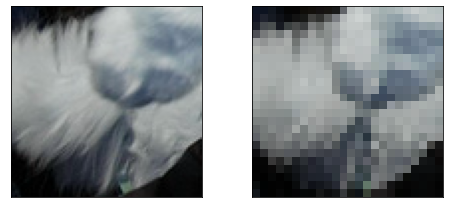

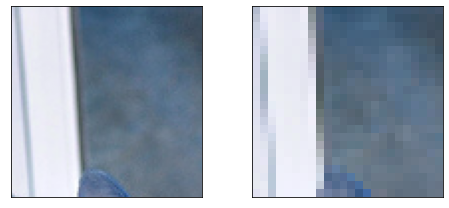

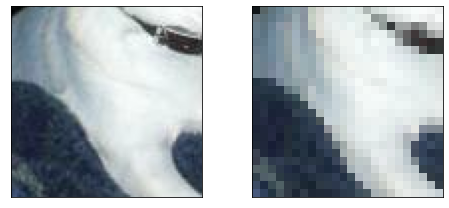

In [4]:

batch_lr_img, batch_hr_img = next(iter(train_gen))

show_num = 3
for i in range(len(batch_hr_img[:show_num])):
    show_batch_imgs(idx=i, demo_ori_img=batch_hr_img[:show_num]/255, demo_lr_img=batch_lr_img[:show_num]/255)


batch_lr_img.shape, batch_hr_img.shape


## training with label smoothing

In [5]:

# generator = models.sr_resnet()
# # SRGAN discriminator
# discriminator = models.discriminator(crop_size, crop_size)


discriminator = models.discriminator(crop_size, crop_size, num_filters=64)
generator = models.sr_resnet(num_filters=64, num_res_blocks=16)


In [6]:
importlib.reload(trainer)

steps_per_epoch = len(train_gen)
learning_rate = PiecewiseConstantDecay(boundaries=[10*steps_per_epoch, 20*steps_per_epoch], values=[1e-4, 1e-5, 1e-6])

gan_trainer = trainer.SrganTrainer(generator, discriminator, label_smoothing=True, noisy_label_prob=0.1, 
                                   adv_loss_weight=0.001,
                                   content_loss='VGG19',
                                   checkpoint_dir='/work/logs/simplication_test',
                                   tf_board_dir='/work/logs/srganx4_train/gradient_tape/',
                                   learning_rate=learning_rate)


In [ ]:

gan_trainer.train(train_gen, val_gen, steps=epochs*steps_per_epoch, test_img_path=val_img_path[:3],
                  scale=scale, evaluate_every=steps_per_epoch)


# # for debugging
# gan_trainer.train([train_gen[0], train_gen[1]], [val_gen[0]], steps=epochs*steps_per_epoch, test_img_path=val_img_path[:3],
#                   scale=scale, evaluate_every=1)


In [ ]:
# # save logs to file

# log_dir = '/work/logs/srganx4/'
# log_file = os.path.join(log_dir, 'srgan.log')

# with open(log_file, 'a') as a_file:
#     for new_line in lines:
#         a_file.write(new_line)
#         a_file.write("\n")

## testing

In [9]:

# evaluate on the entire val data
psnr = utils.evaluate_psnr(gan_trainer.generator, val_gen)
print(psnr)

weights_file = '/work/notebook/srganx4_example.h5'
gan_trainer.generator.save_weights(weights_file)


tf.Tensor(36.083332, shape=(), dtype=float32)


In [10]:
def plot_sample(hr, lr, sr):
    plt.figure(figsize=(25, 10))

    images = [hr, lr, sr]
    titles = ['HR', 'LR', f'SR (x{sr.shape[0] // lr.shape[0]})']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    

In [12]:
def demo(idx, model, scale=scale):
    img_path = val_img_path[idx]
    hr_img, lr_img = utils.process_img(img_path, scale=scale)
    model_input = np.expand_dims(lr_img, 0)
    sr_img = model.predict(model_input)

    plot_sample(hr_img, lr_img, sr_img[0]/255)

In [ ]:

model = models.sr_resnet()
model.load_weights(weights_file)


demo(0, model)


In [ ]:
demo(1, model)

In [15]:
edsr = models.edsr(scale)
edsr.load_weights('edsr_mae_x4.h5')


In [16]:

def plot_compare(idx, scale=scale, model1=edsr, model2=model, patch_size=50, show_patch=True):
    img_path = val_img_path[idx]
    hr_img, lr_img = utils.process_img(img_path, scale=scale)
    
    model_input = np.expand_dims(lr_img, 0)
    pre_sr = model1.predict(model_input)[0]
    gan_sr = model2.predict(model_input)[0]
    
    if show_patch:
        lr_w, lr_h = utils.get_patch_dim(lr_img, patch_size=patch_size)
        sr_w, sr_h = lr_w*(scale), lr_h*(scale)
        lr_img = lr_img[lr_h:lr_h + patch_size, lr_w:lr_w + patch_size]
        pre_sr = pre_sr[sr_h:sr_h + patch_size*(scale), sr_w:sr_w + patch_size*(scale)]
        gan_sr = gan_sr[sr_h:sr_h + patch_size*(scale), sr_w:sr_w + patch_size*(scale)]

    plt.figure(figsize=(20, 20))
    
    images = [lr_img, pre_sr/255, gan_sr/255]
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

In [ ]:
plot_compare(0, show_patch=True)

In [ ]:
plot_compare(1, show_patch=True)